In [1]:
import sdgym
from sdgym import load_dataset
from sdgym import benchmark
from sdgym import load_dataset

In [2]:
from timeit import default_timer as timer
from functools import partial

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
from synthsonic.models.kde_utils import kde_smooth_peaks_1dim, kde_smooth_peaks
from sklearn.model_selection import train_test_split

In [5]:
import pgmpy

from pgmpy.models import BayesianModel
from pgmpy.estimators import TreeSearch

from pgmpy.estimators import HillClimbSearch, BicScore, ExhaustiveSearch
from pgmpy.estimators import BayesianEstimator
from pgmpy.sampling import BayesianModelSampling



In [6]:
import xgboost as xgb
from random import choices

In [7]:
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.svm import SVC

In [8]:
from sklearn.isotonic import IsotonicRegression
from scipy import interpolate

In [9]:
%matplotlib inline

In [10]:
data, categorical_columns, ordinal_columns = load_dataset('alarm')

In [11]:
data.shape

(10000, 37)

In [12]:
data

array([[1., 1., 1., ..., 2., 2., 1.],
       [1., 2., 2., ..., 2., 2., 0.],
       [1., 2., 2., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 2., 2., 2.],
       [1., 1., 1., ..., 2., 2., 2.],
       [1., 1., 1., ..., 2., 2., 0.]])

In [13]:
df = pd.DataFrame(data)
df.columns = [str(i) for i in df.columns]

In [14]:
# learn graph structure (preferred - fast)
est = TreeSearch(df, root_node=df.columns[0])
dag = est.estimate(estimator_type="tan", class_node='1')

Building tree: 100%|██████████| 630/630.0 [00:00<00:00, 679.32it/s]


In [15]:
# alternative graph structure 
if False:
    est2 = TreeSearch(df, root_node=df.columns[0])
    dag2 = est2.estimate(estimator_type="chow-liu")

In [16]:
# alternative graph structure (slow)
if False:
    est = HillClimbSearch(df)

In [17]:
best_model = est.estimate() # start_dag=dag)

Building tree: 100%|██████████| 666/666.0 [00:01<00:00, 598.85it/s]


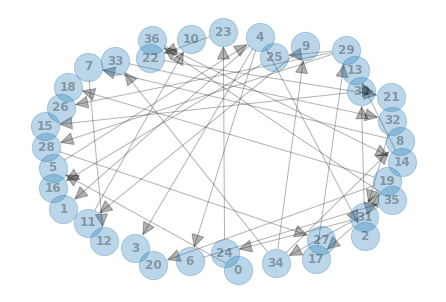

In [18]:
nx.draw(best_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight='bold')
plt.show()

In [19]:
edges = best_model.edges()

In [20]:
edges

OutEdgeView([('0', '5'), ('5', '4'), ('4', '2'), ('4', '1'), ('4', '3'), ('4', '6'), ('6', '35'), ('35', '34'), ('35', '36'), ('34', '8'), ('34', '9'), ('34', '33'), ('36', '14'), ('8', '7'), ('9', '11'), ('33', '32'), ('14', '13'), ('7', '12'), ('11', '10'), ('32', '31'), ('31', '17'), ('31', '30'), ('31', '19'), ('31', '24'), ('17', '29'), ('30', '15'), ('19', '20'), ('19', '18'), ('24', '23'), ('29', '28'), ('29', '26'), ('29', '25'), ('23', '22'), ('28', '27'), ('25', '16'), ('22', '21')])

In [21]:
# there are many choices of parametrization, here is one example
model = BayesianModel(best_model.edges())
model.fit(df, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=0.1)


In [22]:
print(model.get_cpds('2'))

+--------+---------------------+----------------------+----------------------+
| 4      | 4(0.0)              | 4(1.0)               | 4(2.0)               |
+--------+---------------------+----------------------+----------------------+
| 2(0.0) | 0.9506568407561679  | 0.04119231152843281  | 0.011777354249132581 |
+--------+---------------------+----------------------+----------------------+
| 2(1.0) | 0.03962405212004699 | 0.9499593918755254   | 0.041098568147387965 |
+--------+---------------------+----------------------+----------------------+
| 2(2.0) | 0.00971910712378511 | 0.008848296596041775 | 0.9471240776034794   |
+--------+---------------------+----------------------+----------------------+


In [23]:
# set up train-test sample.
# the test sample is used to calibrate the output of the classifier

random_state = 0
X1_train, X1_test, y1_train, y1_test = train_test_split(data, np.ones(data.shape[0]), test_size=0.35,
                                                        random_state=random_state)

In [24]:
X1_train.shape

(6500, 37)

In [25]:
if False:
    clf = MLPClassifier(random_state=0, max_iter=1000, early_stopping=True)

In [26]:
clf = xgb.XGBClassifier(
    n_estimators=250,
    reg_lambda=1,
    gamma=0,
    max_depth=9
)

In [27]:
n_one = len(X1_train)
n_zero = n_one

In [28]:
np.random.seed(seed = 0)

# sample data from BN
inference = BayesianModelSampling(model)
df_data = inference.forward_sample(size=n_zero, return_type='dataframe')

df_data.columns = [int(c) for c in df_data.columns]

X0_train = df_data[sorted(df_data.columns)].values

Generating for node: 2: 100%|██████████| 37/37 [00:00<00:00, 63.35it/s] 


In [29]:
zeros = np.zeros(n_zero)
ones = np.ones(n_one)

yy = np.concatenate([zeros, ones], axis = 0)
XX = np.concatenate([X0_train, X1_train], axis = 0)

In [30]:
clf = clf.fit(XX, yy)

/Users/maxbaak/opt/miniconda3/envs/synthsonic/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [31]:
# calibrate the probabilities, using the test sample and a new null sample

In [32]:
np.random.seed(10)
df_data = inference.forward_sample(size=250000, return_type='dataframe')

df_data.columns = [int(c) for c in df_data.columns]

X0_test = df_data[sorted(df_data.columns)].values

Generating for node: 2: 100%|██████████| 37/37 [00:17<00:00,  2.16it/s] 


In [33]:
p0 = clf.predict_proba(X0_test)[:, 1]
p1 = clf.predict_proba(X1_test)[:, 1]


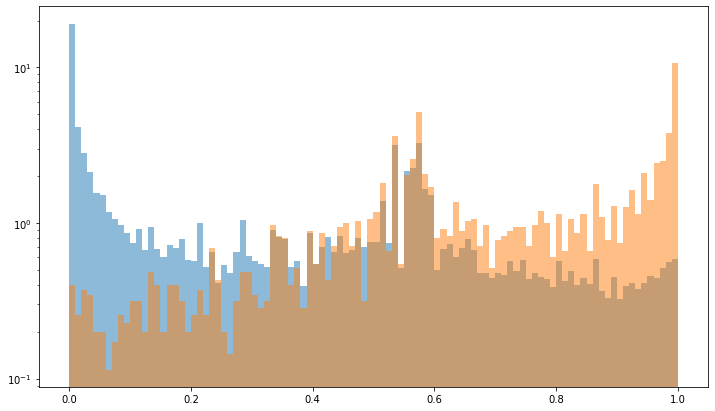

In [34]:
nbins = 100
plt.figure(figsize=(12,7))
plt.hist(p0, bins=100, range=(0,1), alpha=0.5, log=True, density=True);
plt.hist(p1, bins=100, range=(0,1), alpha=0.5, log=True, density=True);


In [35]:
nbins = 100
binning = np.linspace(0, 1, nbins+1)

hist_p0, bin_edges = np.histogram(p0, binning)
hist_p1, bin_edges = np.histogram(p1, binning)

def poisson_uncertainty(n):
    sigman = np.sqrt(n)
    # correct poisson counts of zero.
    sigman[sigman == 0] = 1.
    return sigman

def fraction_and_uncertainty(a, b, sigma_a, sigma_b):
    frac_a = a / (a + b)
    frac_b = b / (a + b)
    sigma_fa2 = np.power(frac_b * sigma_a, 2) / np.power(a + b, 2)  +  np.power(frac_a * sigma_b, 2) / np.power(a + b, 2)
    return frac_a, np.sqrt(sigma_fa2)

rest_p0 = np.sum(hist_p0) - hist_p0
rest_p1 = np.sum(hist_p1) - hist_p1

sigma_bin0 = poisson_uncertainty(hist_p0)
sigma_rest0 = poisson_uncertainty(rest_p0)

sigma_bin1 = poisson_uncertainty(hist_p1)
sigma_rest1 = poisson_uncertainty(rest_p1)

frac0, sigma_frac0 = fraction_and_uncertainty(hist_p0, rest_p0, sigma_bin0, sigma_rest0)
frac1, sigma_frac1 = fraction_and_uncertainty(hist_p1, rest_p1, sigma_bin1, sigma_rest1)

p1calib, sigma_p1calib = fraction_and_uncertainty(frac1, frac0, sigma_frac1, sigma_frac0)

sample_weight = 1 / (sigma_p1calib * sigma_p1calib)
sample_weight /= min(sample_weight)

#sample_weight

In [36]:
# we recalibrate per probability bin. NO interpolation (not valid in highest bin)

#hist_p0, bin_edges = np.histogram(p0, bins=nbins, range=(0, 1))
#hist_p1, bin_edges = np.histogram(p2, bins=nbins, range=(0, 1)) #### !!!! p2
bin_centers = bin_edges[:-1] + 0.5/nbins

hnorm_p0 = hist_p0 / sum(hist_p0)
hnorm_p1 = hist_p1 / sum(hist_p1)
hnorm_sum = hnorm_p0 + hnorm_p1
p1cb = np.divide(hnorm_p1, hnorm_sum, out=np.zeros_like(hnorm_p1), where=hnorm_sum != 0)
# self.p1cb = p1cb, bin_centers

# use isotonic regression to smooth out potential fluctuations in the p1 values
# isotonic regression assumes that p1 can only be a rising function.
# I’m assuming that if a classifier predicts a higher probability, the calibrated probability
# will also be higher. This may not always be right, but I think generally it is a safe one.
iso_reg = IsotonicRegression(y_min=0, y_max=1).fit(bin_centers, p1calib, sample_weight)
p1pred = iso_reg.predict(bin_centers)

# calibrated probabilities
p1f_ = interpolate.interp1d(bin_edges[:-1], p1pred, kind='previous', bounds_error=False, fill_value="extrapolate")

p1pred = p1f_(bin_centers)

In [37]:
p1lin = p1f_(bin_centers)


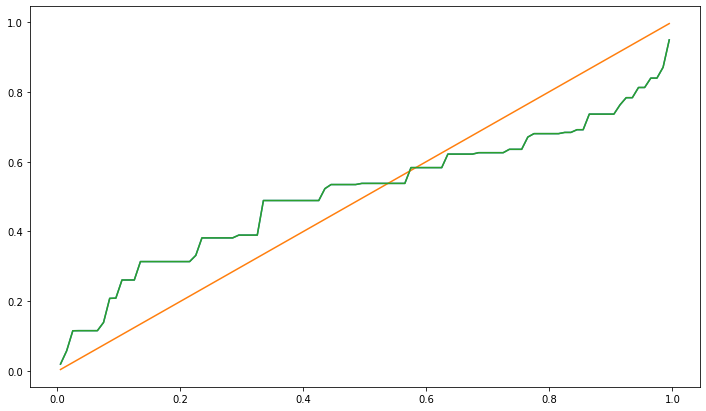

In [38]:
plt.figure(figsize=(12,7))
#plt.plot(bin_centers, p1cb)
plt.plot(bin_centers, p1pred)
plt.plot(bin_centers, bin_centers)
plt.plot(bin_centers, p1lin)

In [39]:
maxp1 = p1f_(0.995)

In [40]:
max_weight = maxp1 / (1. - maxp1)
max_weight

18.321282001172552

In [ ]:
# validation - part 1: check if reweighting works okay

In [41]:
from pgmpy.sampling import BayesianModelSampling

np.random.seed(1)

# sample data from BN
inference = BayesianModelSampling(model)

df_data = inference.forward_sample(size=250000, return_type='dataframe')

df_data.columns = [int(c) for c in df_data.columns]

X_test = df_data[sorted(df_data.columns)].values

Generating for node: 2: 100%|██████████| 37/37 [00:20<00:00,  1.85it/s] 


In [42]:
p0 = clf.predict_proba(X_test)[:, 1]
nominator = p1f_(p0)
denominator = 1 - nominator
weight = np.divide(nominator, denominator, out=np.ones_like(nominator), where=denominator != 0)

In [43]:
len(X_test), sum(weight)

(250000, 253237.66351335566)

In [44]:
if False:
    keep = weight == max_weight
    same = weight != max_weight
    ratio = (250000 - np.sum(weight[same])) / np.sum(weight[keep])
    np.sum(weight[same]), np.sum(weight[keep])


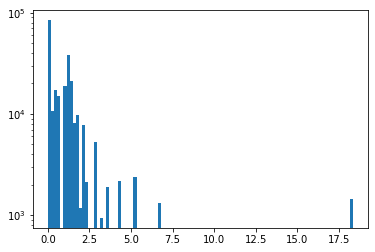

In [45]:
plt.hist(weight, bins=100, log=True);

In [47]:
#data, sample_weights = self._sample_no_transform(n_samples, random_state)
pop = np.asarray(range(X_test.shape[0]))
probs = weight/np.sum(weight)
sample = choices(pop, probs, k=X_test.shape[0])
Xtrans = X_test[sample]


In [48]:
p0 = clf.predict_proba(Xtrans)[:, 1]
p1 = clf.predict_proba(X1_test)[:, 1]


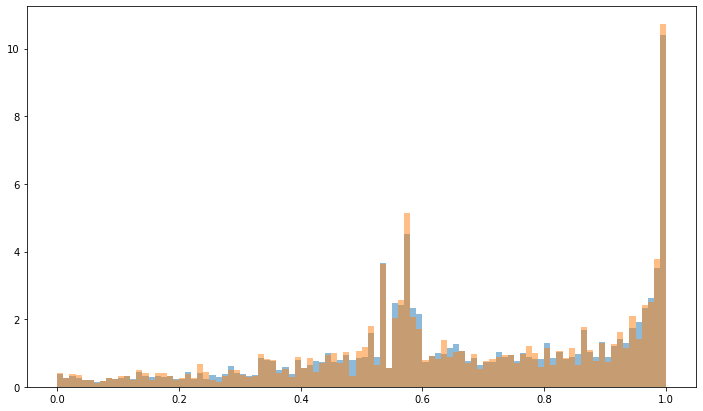

In [49]:
plt.figure(figsize=(12,7))
plt.hist(p0, bins=100, range=(0,1), alpha=0.5, density=True); #, weights=weight)#, log=True)
plt.hist(p1, bins=100, range=(0,1), alpha=0.5, density=True);


In [50]:
# validation - part 2: plot distributions

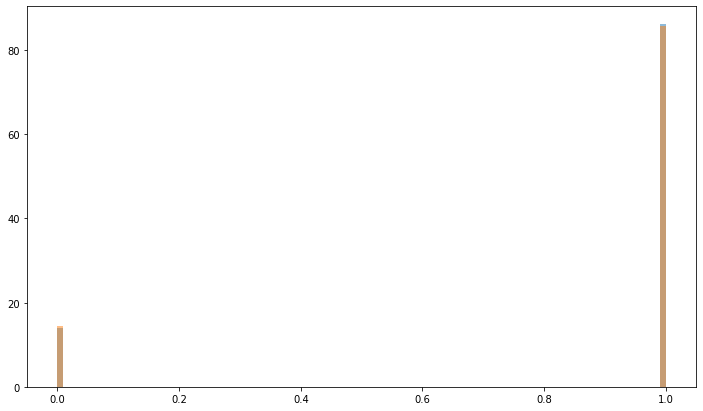

In [51]:
i = 1
plt.figure(figsize=(12,7))
plt.hist(X_test[:, i], bins=100, range=(0,1), alpha=0.5, density=True);#, log=True)
plt.hist(X1_test[:, i], bins=100, range=(0,1), alpha=0.5, density=True);


In [52]:
# validation part 3: check number of duplicates

In [53]:
np.random.seed(2)
df_data = inference.forward_sample(size=500000, return_type='dataframe')
df_data.columns = [int(c) for c in df_data.columns]
X10k = df_data[sorted(df_data.columns)].values

Generating for node: 2: 100%|██████████| 37/37 [00:35<00:00,  1.05it/s] 


In [54]:
p0 = clf.predict_proba(X10k)[:, 1]
nominator = p1f_(p0)
denominator = 1 - nominator
weight = np.divide(nominator, denominator, out=np.ones_like(nominator), where=denominator != 0)

In [55]:
sum(weight)

506307.74954655964

In [56]:
pop = np.asarray(range(X10k.shape[0]))
probs = weight/np.sum(weight)
sample = choices(pop, probs, k=X10k.shape[0])
Xtrans = X10k[sample]


In [57]:
u, c = np.unique(Xtrans, axis=0, return_counts=True)

In [58]:
counts = np.sort(c)[::-1] / 50

In [59]:
counts

array([1.8616e+02, 1.7008e+02, 1.5678e+02, ..., 2.0000e-02, 2.0000e-02,
       2.0000e-02])

In [60]:
u, c = np.unique(data, axis=0, return_counts=True)

In [61]:
c2 = np.sort(c)[::-1] 

<BarContainer object of 40 artists>

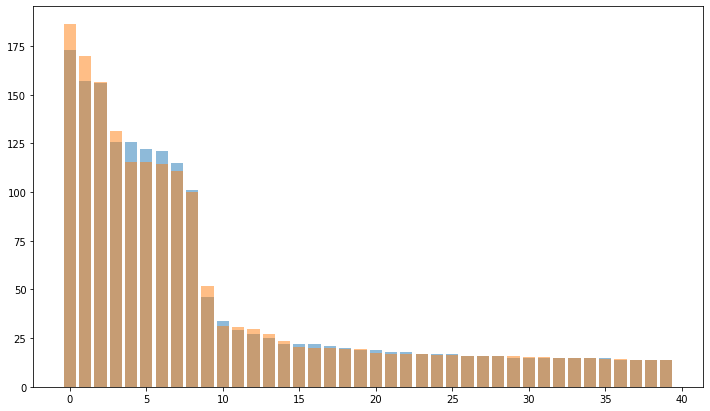

In [62]:
plt.figure(figsize=(12,7))
plt.bar(list(range(40)), c2[:40], alpha=0.5)
plt.bar(list(range(40)), counts[:40], alpha=0.5)


In [63]:
# run sdgym

In [64]:

df = pd.DataFrame(Xtrans)
df.to_csv('test.csv', index=False)


In [65]:
def KDECopulaNNPdf_RoundCategorical(real_data, categorical_columns, ordinal_columns, times=None):
    df = pd.read_csv('test.csv')
    data = df.values[:50000]
    return data

In [66]:
import sdgym

scores = sdgym.run(synthesizers=KDECopulaNNPdf_RoundCategorical, datasets=['alarm'])

In [67]:
scores

,alarm/syn_likelihood,alarm/test_likelihood,timestamp
VEEGANSynthesizer,-18.386073,-18.210907,2020-04-12 09:41:35.096775
CLBNSynthesizer,-12.458848,-11.187805,2020-10-17 09:46:54.494331
CTGAN,-15.882041,-13.097559,2020-10-17 09:46:54.494331
CTGANSynthesizer,-15.220448,-12.928010,2020-10-17 09:46:54.494331
CopulaGAN,-15.688131,-13.052851,2020-10-17 09:46:54.494331
GaussianCopulaCategorical,-12.906379,-15.574882,2020-10-17 09:46:54.494331
GaussianCopulaCategoricalFuzzy,-14.521543,-14.565064,2020-10-17 09:46:54.494331
GaussianCopulaOneHot,-15.476064,-15.666336,2020-10-17 09:46:54.494331
IdentitySynthesizer,-10.231837,-10.300455,2020-10-17 09:46:54.494331
IndependentSynthesizer,-18.239966,-15.818331,2020-10-17 09:46:54.494331
